In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
from tools import reduce_mem_usage, chk_dist
from wordcloud import WordCloud
from collections import defaultdict
import matplotlib.font_manager as fm

In [2]:
# 글꼴 한국어도 가능하도록 설정
path = 'c:\\windows\\fonts\\NanumBarunGothic.ttf'
font_name = fm.FontProperties(fname=path, size=50).get_name()
plt.rc('font', family=font_name)

# DIR 설정
data_dir = 'C:\\Users\\CSH\\Desktop\\lpoint\\data\\'

In [3]:
product = pd.read_csv(data_dir + 'product.csv')
product.info()

C:\Users\CSH\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2698: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5024906 entries, 0 to 5024905
Data columns (total 8 columns):
CLNT_ID      int64
SESS_ID      int64
HITS_SEQ     int64
PD_C         int64
PD_ADD_NM    object
PD_BRA_NM    object
PD_BUY_AM    object
PD_BUY_CT    object
dtypes: int64(4), object(4)
memory usage: 306.7+ MB


In [4]:
product['PD_BUY_CT'] = product['PD_BUY_CT'].apply(lambda x: str(x))
product['PD_BUY_CT'] = product['PD_BUY_CT'].apply(lambda x: int(x.replace(',','')))

Session ID 별로 구매 건수에 대한 정보를 파악하기 위해 위 데이터를 CLNT ID, Session ID 를 기준으로 묶겠다.

In [5]:
buy_cnt_sess = product[['CLNT_ID', 'SESS_ID', 'PD_BUY_CT']].groupby(
    ['CLNT_ID', 'SESS_ID'], as_index=False).sum()

chk_dist(buy_cnt_sess['PD_BUY_CT'], "구매 건수")

평균 구매 건수는 2.182 건, 상위 99%의 구매 건수는 11 건이며 최고 구매 건수는 2420 건이다.


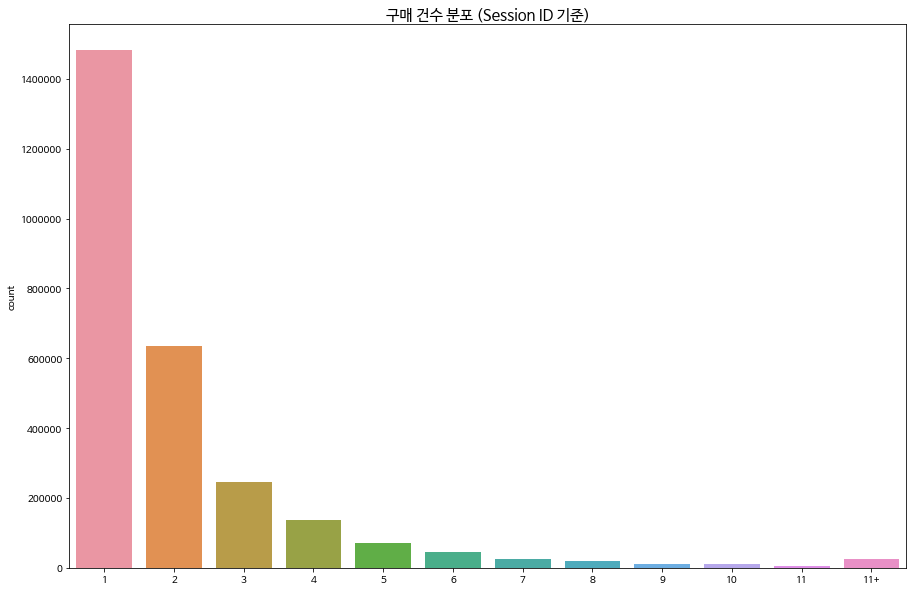

In [6]:
data = buy_cnt_sess.copy()
data.loc[data['PD_BUY_CT'] > data['PD_BUY_CT'].quantile(0.99)] = '11+'
plt.figure(figsize=(15,10))
sns.countplot(sorted(data['PD_BUY_CT'].astype(str), key = lambda x: x if len(x) == 1 else '9' + x))
plt.title('구매 건수 분포 (Session ID 기준)', fontsize = 15)
plt.show()

구매 건수가 다른 변수들과 어떤 상관 관계를 보이는지 한번 살펴보겠다. 먼저 총 페이지 조회 건수가 구매 건수와 어떤 관계를 보이는지 살펴보겠다.

# 총 페이지 조회 건수

In [7]:
session = pd.read_csv(data_dir + 'session.csv')
session.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2712907 entries, 0 to 2712906
Data columns (total 9 columns):
CLNT_ID            int64
SESS_ID            int64
SESS_SEQ           int64
SESS_DT            int64
TOT_PAG_VIEW_CT    float64
TOT_SESS_HR_V      object
DVC_CTG_NM         object
ZON_NM             object
CITY_NM            object
dtypes: float64(1), int64(4), object(4)
memory usage: 186.3+ MB


C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


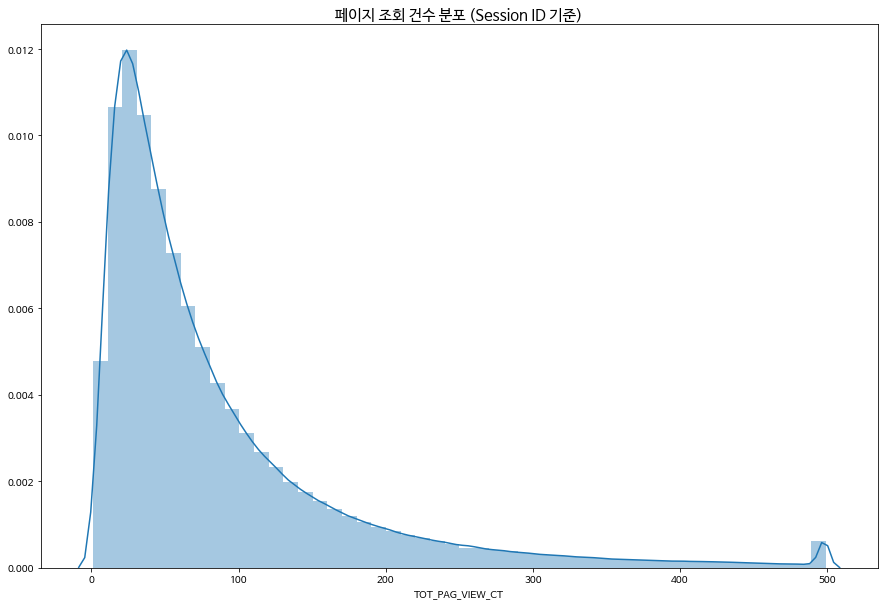

In [8]:
data = session['TOT_PAG_VIEW_CT'][~session['TOT_PAG_VIEW_CT'].isnull()]
plt.figure(figsize = (15,10))
plt.title("페이지 조회 건수 분포 (Session ID 기준)", fontsize=15)
sns.distplot(data)
plt.show()

In [9]:
chk_dist(session['TOT_PAG_VIEW_CT'], "페이지 조회 건수")

평균 페이지 조회 건수는 85.168 건, 상위 99%의 페이지 조회 건수는 448 건이며 최고 페이지 조회 건수는 499 건이다.


In [10]:
buy_cnt_sess_merged = buy_cnt_sess.merge(session, on = ['CLNT_ID', 'SESS_ID'], how = 'left')
buy_cnt_sess_merged.isnull().sum(axis=0)

CLNT_ID                0
SESS_ID                0
PD_BUY_CT              0
SESS_SEQ               0
SESS_DT                0
TOT_PAG_VIEW_CT      274
TOT_SESS_HR_V      14202
DVC_CTG_NM             0
ZON_NM                 0
CITY_NM                0
dtype: int64

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


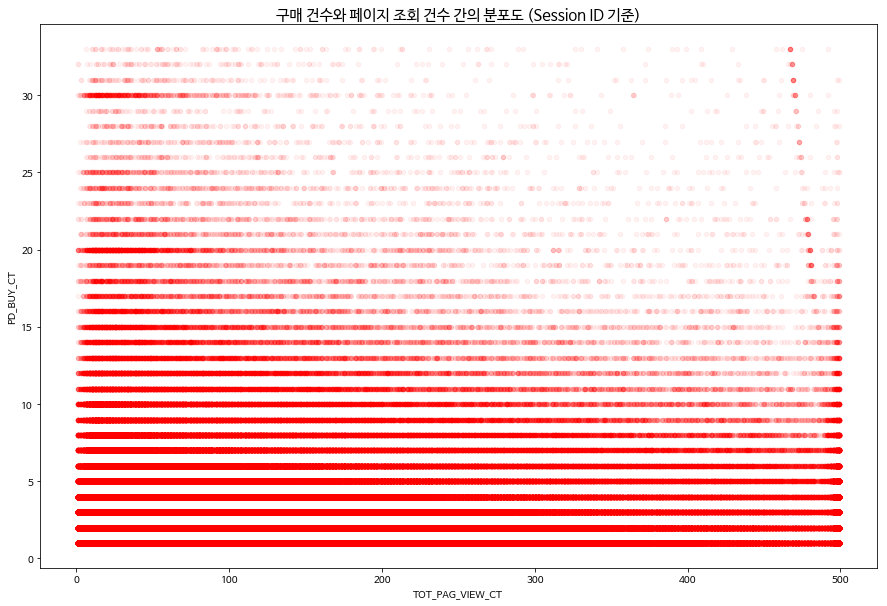

In [11]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_PAG_VIEW_CT'].isnull()][buy_cnt_sess_merged['PD_BUY_CT']<[buy_cnt_sess_merged['PD_BUY_CT'].quantile(0.999)]]
data.plot(kind='scatter', x="TOT_PAG_VIEW_CT", y="PD_BUY_CT", alpha=0.05, color='red',
         figsize=(15,10))
plt.title('구매 건수와 페이지 조회 건수 간의 분포도 (Session ID 기준)', fontsize=15)
plt.show()

전반적으로 살짝 반비례하는 모습을 보인다.

# 총 세션 시간 값

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':
C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


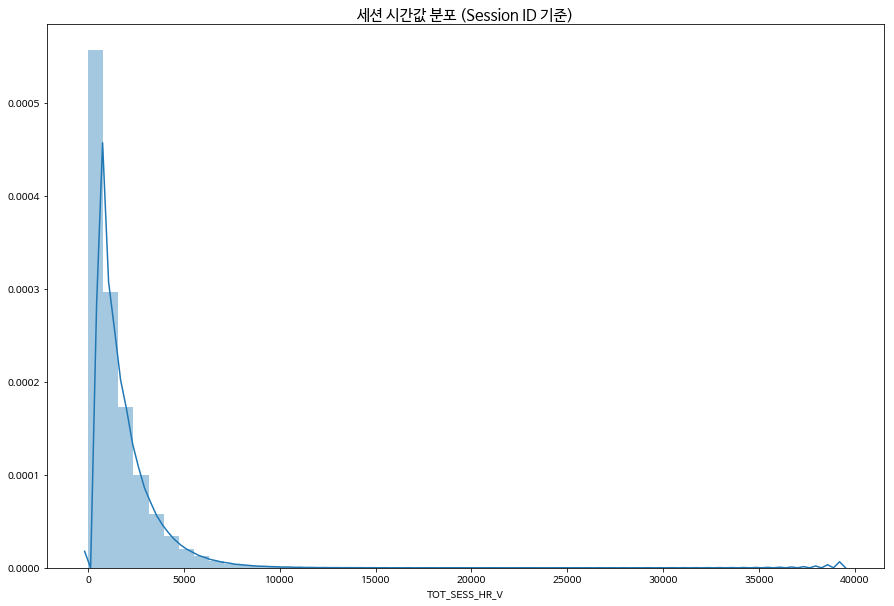

In [12]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_SESS_HR_V'].isnull()][buy_cnt_sess_merged['PD_BUY_CT']<50]
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(x.replace(',','')))
plt.figure(figsize = (15,10))
plt.title("세션 시간값 분포 (Session ID 기준)", fontsize=15)
sns.distplot(data['TOT_SESS_HR_V'])
plt.show()

In [13]:
data = session['TOT_SESS_HR_V']
data = data[~data.isnull()]
data = data.apply(lambda x: int(x.replace(',','')))
chk_dist(data, "세션 시간 값")

평균 세션 시간 값는 1451.583 건, 상위 99%의 세션 시간 값는 6989 건이며 최고 세션 시간 값는 39329 건이다.


C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


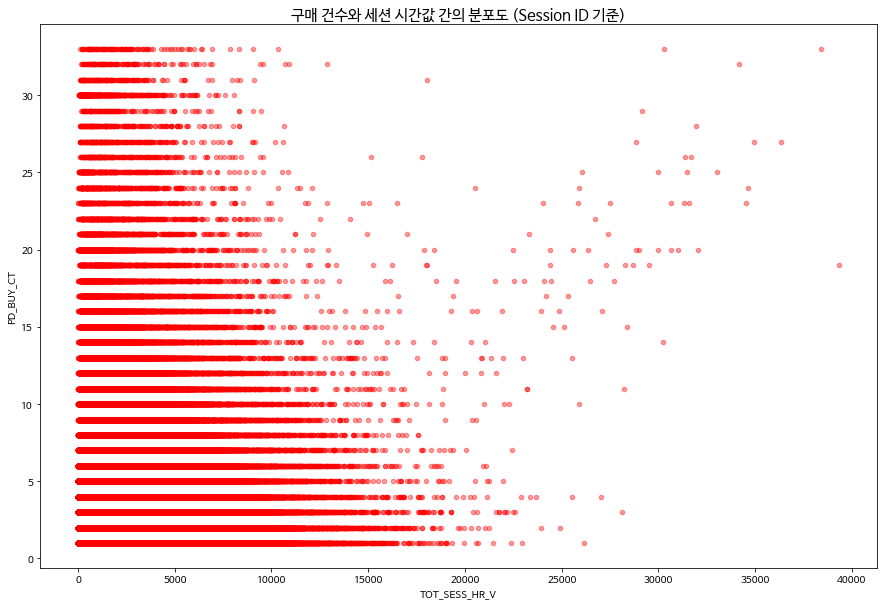

In [14]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_SESS_HR_V'].isnull()][buy_cnt_sess_merged['PD_BUY_CT']<buy_cnt_sess_merged['PD_BUY_CT'].quantile(0.999)]
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(x.replace(",","")))
data.plot(kind='scatter', x='TOT_SESS_HR_V', y="PD_BUY_CT", alpha=0.4, color='red',
         figsize=(15,10))
plt.title('구매 건수와 세션 시간값 간의 분포도 (Session ID 기준)', fontsize=15)
plt.show()

세션 시간값이 20,000초 이전에는 반비례하는 모습을 보이고, 20,000초 이후로는 미약하게나마 정비례하는 모습을 보인다.

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if __name__ == '__main__':


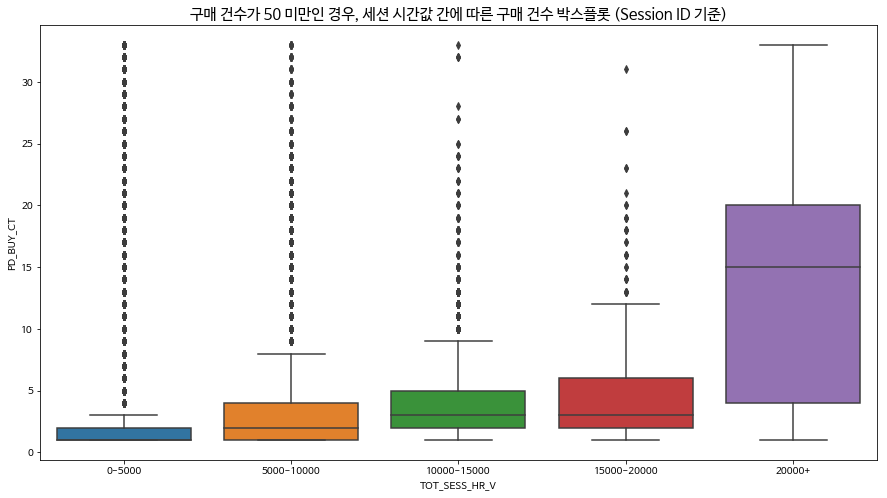

In [15]:
data = buy_cnt_sess_merged[~buy_cnt_sess_merged['TOT_SESS_HR_V'].isnull()][buy_cnt_sess_merged['PD_BUY_CT']<buy_cnt_sess_merged['PD_BUY_CT'].quantile(0.999)]
data['TOT_SESS_HR_V'] = data['TOT_SESS_HR_V'].apply(lambda x: int(x.replace(',','')))
data['TOT_SESS_HR_V'] = pd.cut(data['TOT_SESS_HR_V'], [0, 5000,10000, 15000, 20000, 10e+10],
                              labels = ['0-5000', '5000-10000', '10000-15000', '15000-20000', '20000+'])
plt.figure(figsize=(15,8))
plt.title("구매 건수가 50 미만인 경우, 세션 시간값 간에 따른 구매 건수 박스플롯 (Session ID 기준)", fontsize=15)
sns.boxplot(x='TOT_SESS_HR_V', y='PD_BUY_CT', data=data)
plt.show()

세션 시간값 20,000초 이후로는 구매 건수가 확연히 높아짐을 볼 수 있다.

# 기기 유형

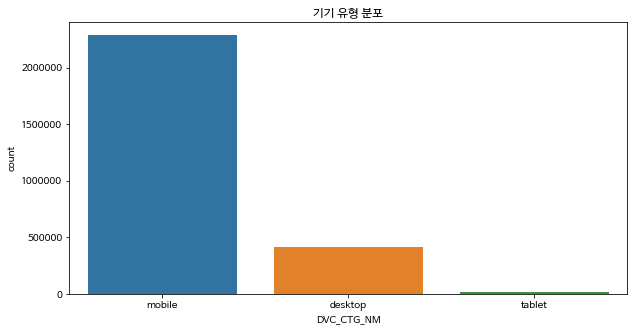

In [16]:
data =session['DVC_CTG_NM']
plt.figure(figsize=(10,5))
sns.countplot(data)
plt.title("기기 유형 분포")
plt.show()

In [17]:
data =session['DVC_CTG_NM']
print("mobile로는 총 %d 번, desktop로는 총 %d 번, tablet로는 총 %d 번의 거래가 이루어졌다." % ((data=='mobile').sum(), 
                                                                         (data=='desktop').sum(), (data=='tablet').sum()))

mobile로는 총 2289681 번, desktop로는 총 411169 번, tablet로는 총 12057 번의 거래가 이루어졌다.


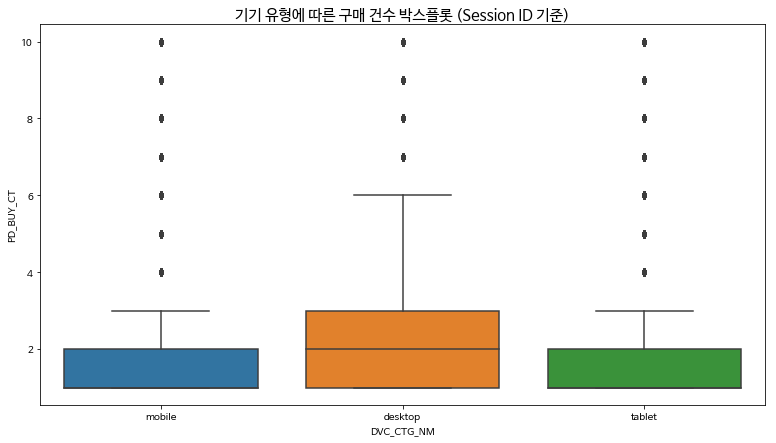

mobile 고객들의 평균 구매 건수는 1.864522 건, desktop 고객들의 평균 구매 건수는 2.337450 건, tablet 고객들의 평균 구매 건수는 2.019525 건이다


In [18]:
data = buy_cnt_sess_merged[buy_cnt_sess_merged['PD_BUY_CT'] < buy_cnt_sess_merged['PD_BUY_CT'].quantile(0.99)]
plt.figure(figsize=(13,7))
sns.boxplot(x = 'DVC_CTG_NM', y = 'PD_BUY_CT', data=data)
plt.title("기기 유형에 따른 구매 건수 박스플롯 (Session ID 기준)", fontsize=15)
plt.show()
print("mobile 고객들의 평균 구매 건수는 %f 건, desktop 고객들의 평균 구매 건수는 %f 건, tablet 고객들의 평균 구매 건수는 %f 건이다"\
      %(data[data['DVC_CTG_NM']=='mobile']['PD_BUY_CT'].mean(), data[data['DVC_CTG_NM']=='desktop']['PD_BUY_CT'].mean(),
       data[data['DVC_CTG_NM']=='tablet']['PD_BUY_CT'].mean()))

Desktop 고객들이 가장 구매 건수가 높고, 그 다음으로 Tablet 고객, Mobile 고객 임을 알 수 있다. 

# 지역대분류

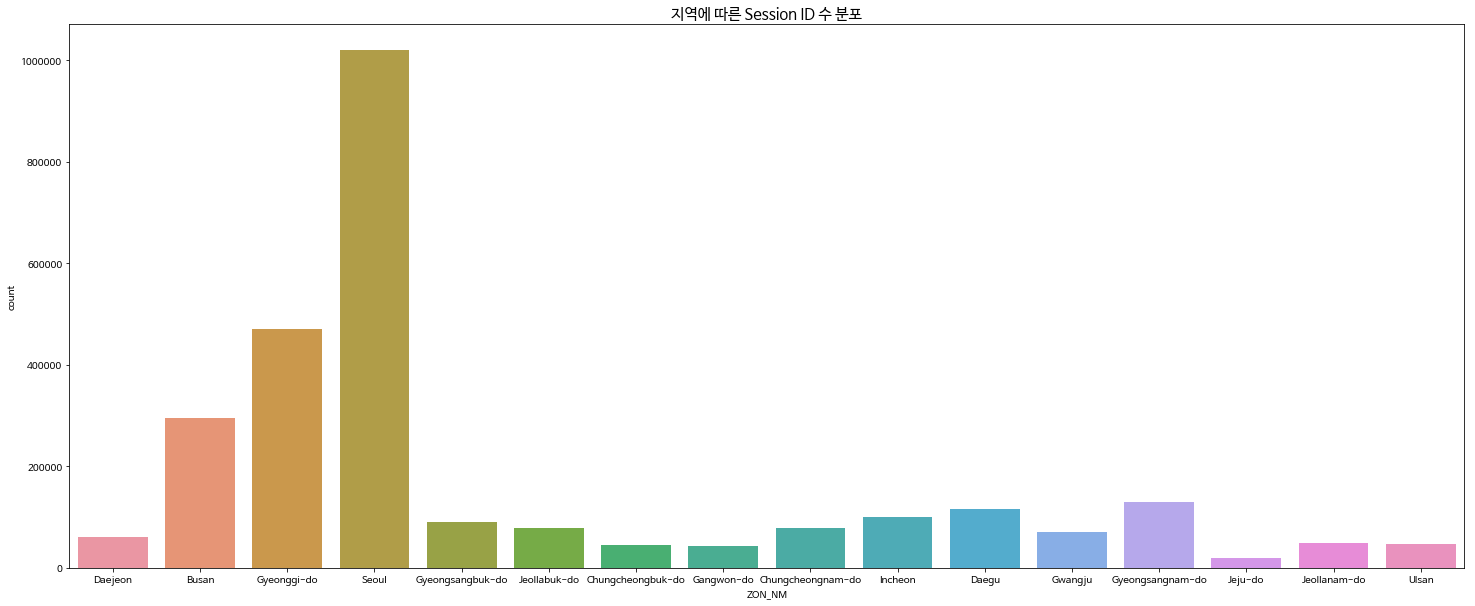

In [19]:
data =session['ZON_NM']
plt.figure(figsize=(25,10))
sns.countplot(data)
plt.title("지역에 따른 Session ID 수 분포", fontsize=15)
plt.show()

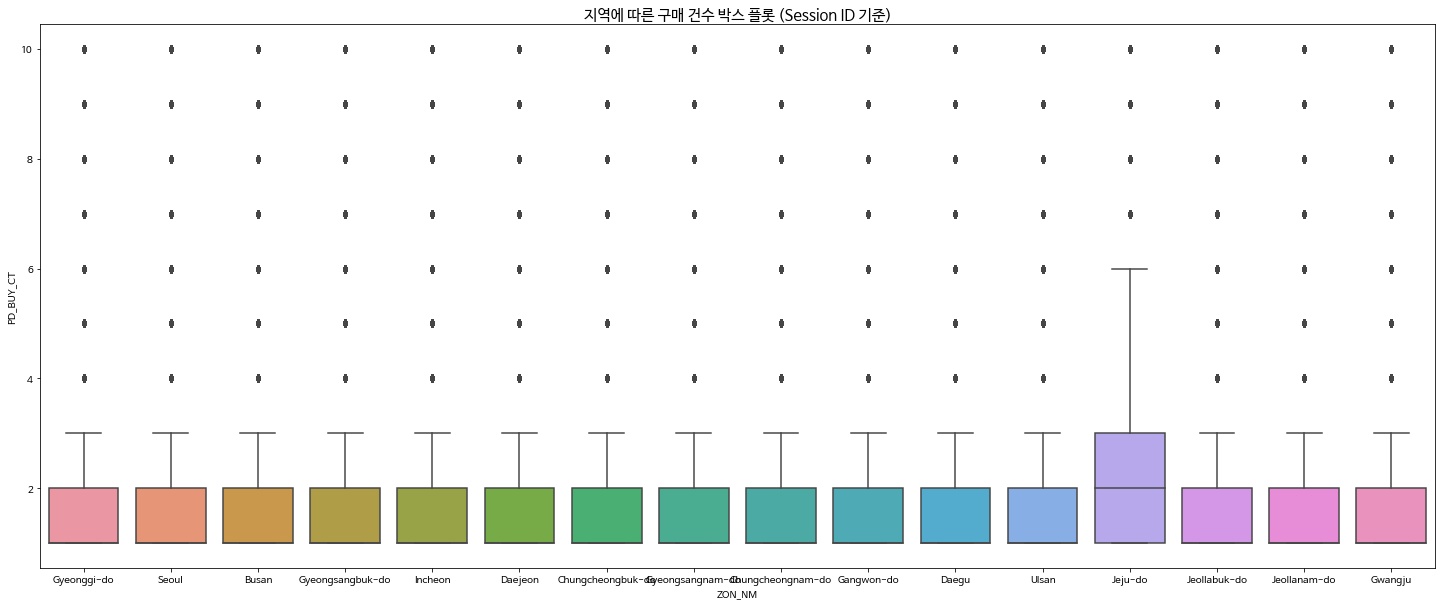

Gyeonggi-do 의 평균 구매 건수 : 1.952725 건
Seoul 의 평균 구매 건수 : 1.882643 건
Busan 의 평균 구매 건수 : 1.923000 건
Gyeongsangbuk-do 의 평균 구매 건수 : 2.003166 건
Incheon 의 평균 구매 건수 : 1.948814 건
Daejeon 의 평균 구매 건수 : 1.975351 건
Chungcheongbuk-do 의 평균 구매 건수 : 2.010937 건
Gyeongsangnam-do 의 평균 구매 건수 : 1.987385 건
Chungcheongnam-do 의 평균 구매 건수 : 2.026899 건
Gangwon-do 의 평균 구매 건수 : 2.000071 건
Daegu 의 평균 구매 건수 : 1.936361 건
Ulsan 의 평균 구매 건수 : 1.966541 건
Jeju-do 의 평균 구매 건수 : 2.123274 건
Jeollabuk-do 의 평균 구매 건수 : 2.015678 건
Jeollanam-do 의 평균 구매 건수 : 2.056949 건
Gwangju 의 평균 구매 건수 : 1.997154 건


In [20]:
data = buy_cnt_sess_merged[buy_cnt_sess_merged['PD_BUY_CT'] < buy_cnt_sess_merged['PD_BUY_CT'].quantile(0.99)]
plt.figure(figsize=(25,10))
plt.title("지역에 따른 구매 건수 박스 플롯 (Session ID 기준)", fontsize=15)
sns.boxplot(x = 'ZON_NM', y = 'PD_BUY_CT', data=data)
plt.show()

zon_list = data['ZON_NM'].unique()
for zon in zon_list:
    print("%s 의 평균 구매 건수 : %f 건" %(zon, data[data['ZON_NM']==zon]['PD_BUY_CT'].mean()))

의외로 평균 구매 건수가 가장 높은 지역은 제주도, 가장 낮은 지역은 서울인 것으로 드러났다. 지역별 1인당 gdp가 가장 큰 곳이 서울인 것을 감안할 때 예상 밖의 결과라고 할 수 있다. 과연 구매 건수말고 구매 총액에서도 그럴지 알아보겠다.

In [21]:
product['PD_BUY_AM'] = product['PD_BUY_AM'].apply(lambda x: int(x.replace(',','')))
buy_amnt_sess = product[['CLNT_ID', 'SESS_ID', 'PD_BUY_AM']].groupby(['CLNT_ID', 'SESS_ID'], as_index=False).sum()
buy_amnt_sess_merged = buy_amnt_sess.merge(session, on=['CLNT_ID', 'SESS_ID'], how='left')

C:\Users\CSH\Anaconda3\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


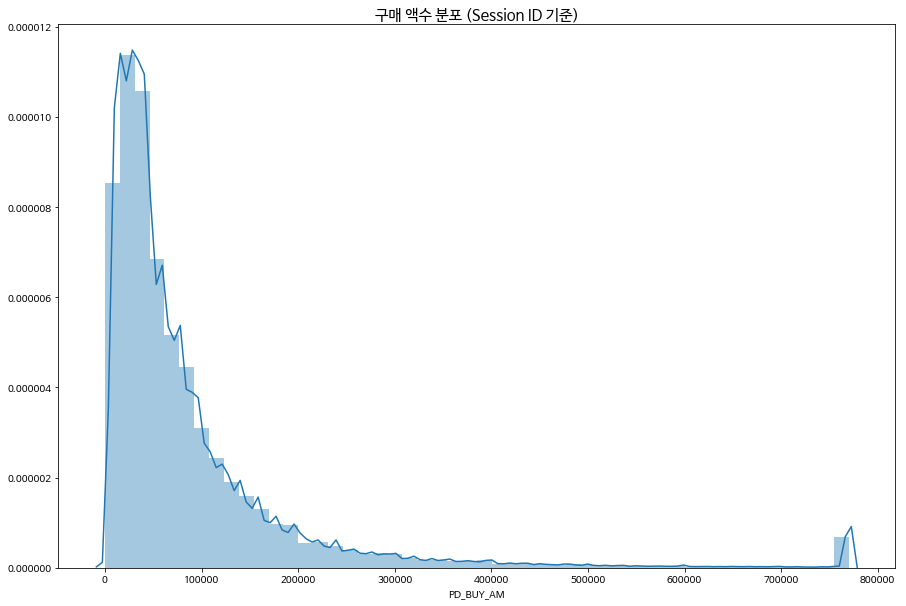

In [22]:
data = buy_amnt_sess_merged['PD_BUY_AM']
data[data>data.quantile(0.99)] = data.quantile(0.99)
plt.figure(figsize = (15,10))
plt.title("구매 액수 분포 (Session ID 기준)", fontsize=15)
sns.distplot(data)
plt.show()

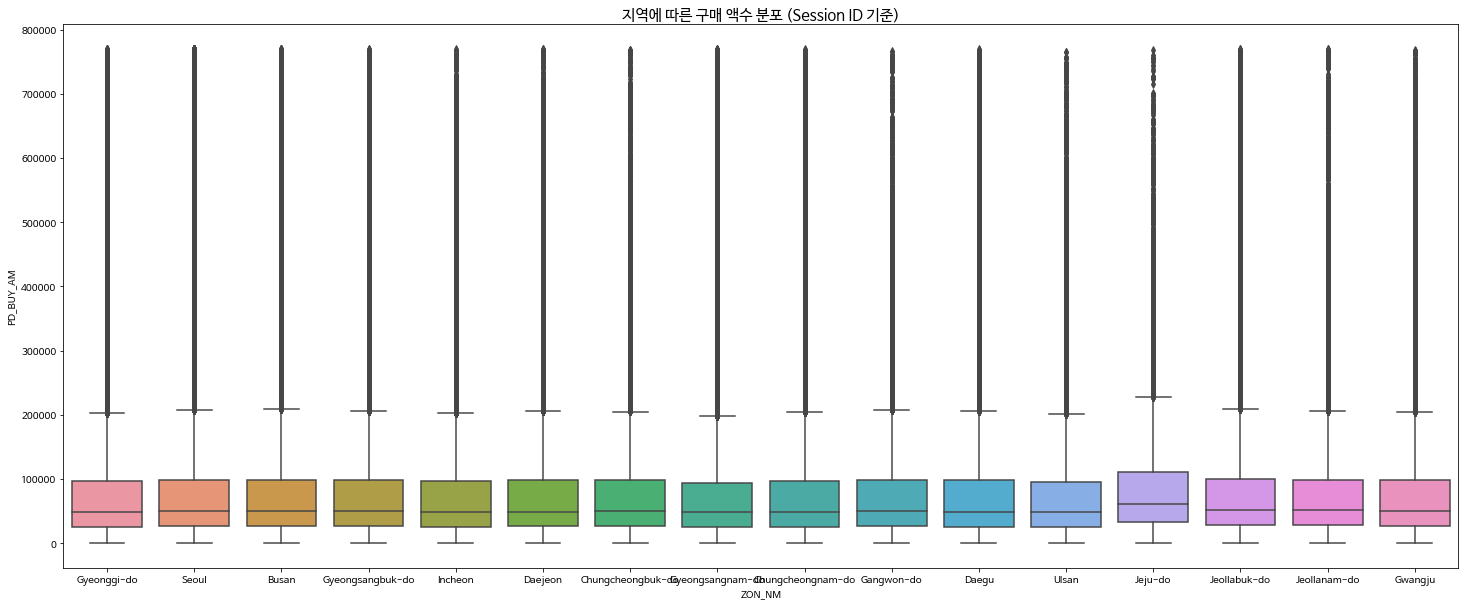

Gyeonggi-do 의 평균 구매 액수 : 78505.027784 원
Seoul 의 평균 구매 액수 : 81704.804206 원
Busan 의 평균 구매 액수 : 80632.557025 원
Gyeongsangbuk-do 의 평균 구매 액수 : 79507.467060 원
Incheon 의 평균 구매 액수 : 78115.244429 원
Daejeon 의 평균 구매 액수 : 79798.480831 원
Chungcheongbuk-do 의 평균 구매 액수 : 80562.354516 원
Gyeongsangnam-do 의 평균 구매 액수 : 76391.426167 원
Chungcheongnam-do 의 평균 구매 액수 : 78943.533281 원
Gangwon-do 의 평균 구매 액수 : 80426.189193 원
Daegu 의 평균 구매 액수 : 79037.191515 원
Ulsan 의 평균 구매 액수 : 77372.076740 원
Jeju-do 의 평균 구매 액수 : 91652.067415 원
Jeollabuk-do 의 평균 구매 액수 : 82773.261503 원
Jeollanam-do 의 평균 구매 액수 : 80875.614974 원
Gwangju 의 평균 구매 액수 : 80234.224970 원


In [23]:
data = buy_amnt_sess_merged[buy_amnt_sess_merged['PD_BUY_AM'] < buy_amnt_sess_merged['PD_BUY_AM'].quantile(0.99)]
plt.figure(figsize=(25,10))
sns.boxplot(x = 'ZON_NM', y = 'PD_BUY_AM', data=data)
plt.title("지역에 따른 구매 액수 분포 (Session ID 기준)", fontsize=15)
plt.show()

zon_list = data['ZON_NM'].unique()
for zon in zon_list:
    print("%s 의 평균 구매 액수 : %f 원" %(zon, data[data['ZON_NM']==zon]['PD_BUY_AM'].mean()))

지역마다 큰 차이가 거의 없는 반면에 제주도는 비교적 높은 것을 알 수 있다. 제주도의 구매 성향을 파악해보자

# 제주도 고객들의 페이지 조회수, 세션 시간값 분포 파악하기

In [24]:
session['TOT_PAG_VIEW_CT'].dropna(inplace=True)

C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


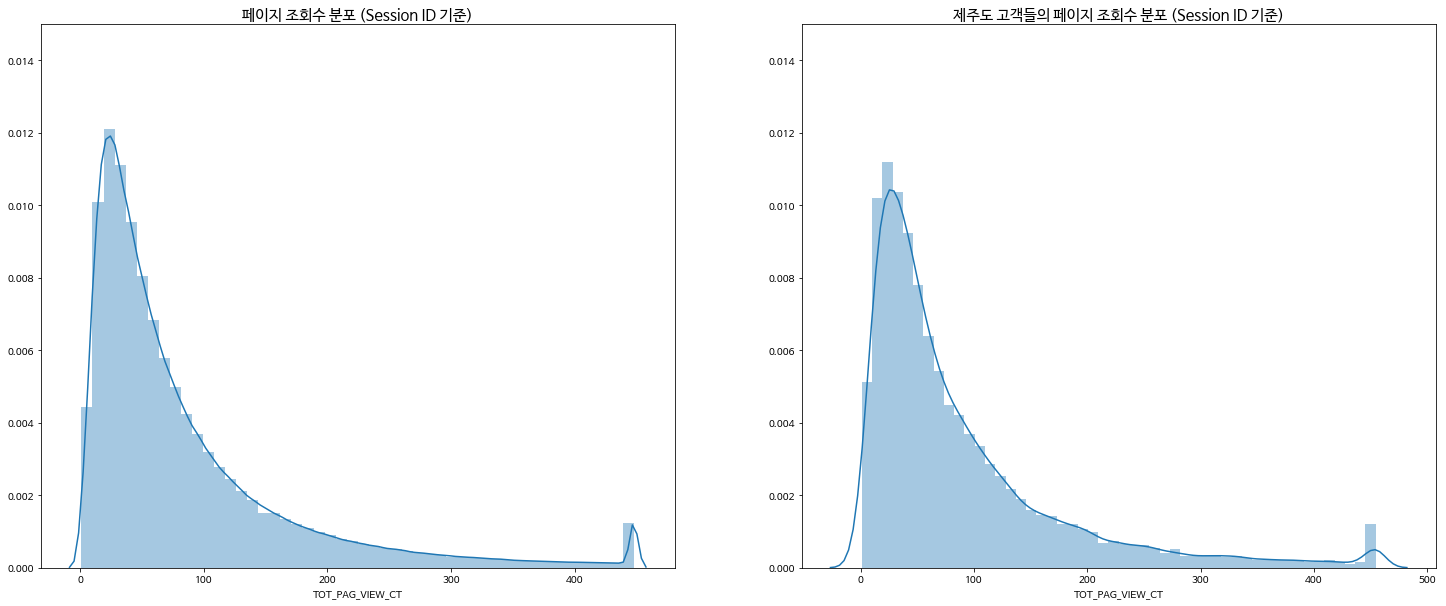

In [25]:
f,ax = plt.subplots(1,2, figsize = (25,10))

data = session['TOT_PAG_VIEW_CT'].dropna()
data[data>data.quantile(0.99)] = data.quantile(0.99)
ax[0].set_title("페이지 조회수 분포 (Session ID 기준)", fontsize=15)
ax[0].set_ylim(0,0.015)
sns.distplot(data, ax=ax[0])

data = session[session['ZON_NM']=='Jeju-do']['TOT_PAG_VIEW_CT'].dropna()
data[data>data.quantile(0.99)] = data.quantile(0.99)
ax[1].set_title("제주도 고객들의 페이지 조회수 분포 (Session ID 기준)", fontsize=15)
ax[1].set_ylim(0,0.015)
sns.distplot(data, ax=ax[1])
plt.show()

C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


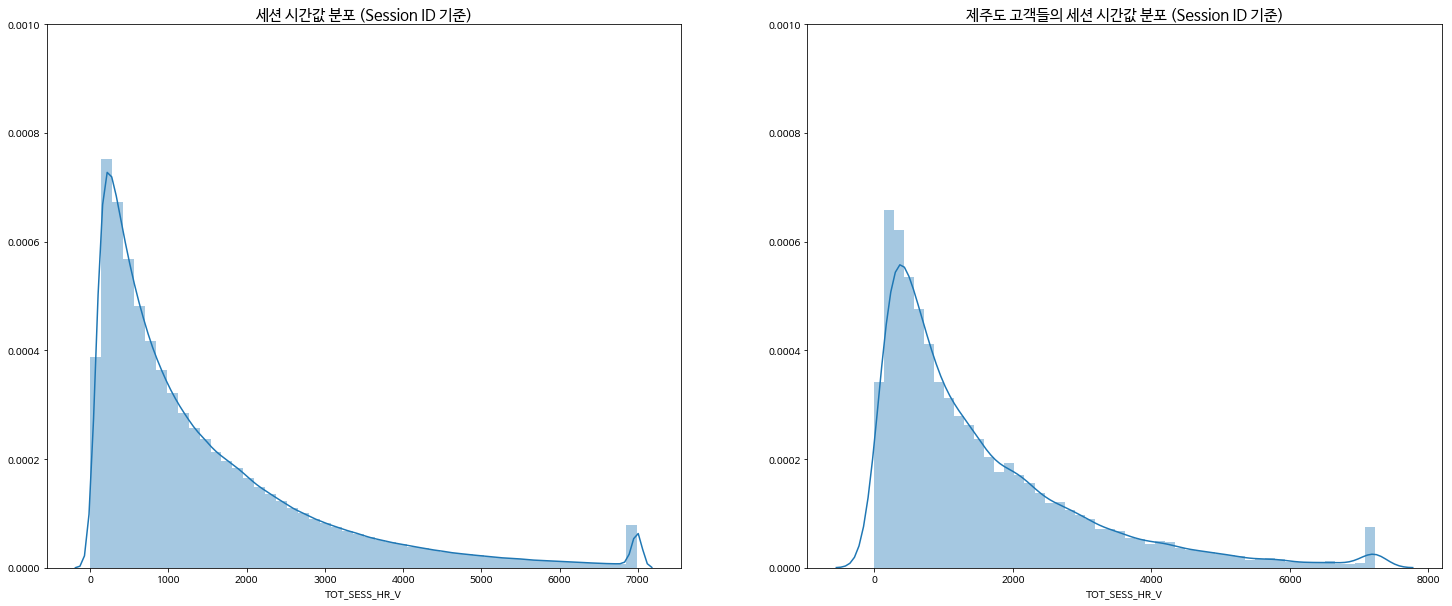

In [26]:
f,ax = plt.subplots(1,2, figsize = (25,10))

data = session['TOT_SESS_HR_V'].dropna().apply(lambda x:int(str(x).replace('.','').replace(',','')))
data[data>data.quantile(0.99)] = data.quantile(0.99)
ax[0].set_title("세션 시간값 분포 (Session ID 기준)", fontsize=15)
ax[0].set_ylim(0,0.001)
sns.distplot(data, ax=ax[0])

data = session['TOT_SESS_HR_V'].dropna().apply(lambda x:int(str(x).replace('.','').replace(',','')))[session['ZON_NM']=='Jeju-do']
data[data>data.quantile(0.99)] = data.quantile(0.99)
ax[1].set_title("제주도 고객들의 세션 시간값 분포 (Session ID 기준)", fontsize=15)
ax[1].set_ylim(0,0.001)
sns.distplot(data, ax=ax[1])
plt.show()

제주도 고객들의 페이지 조회수 분포와 세션 시간값 분포는 전체 고객들의 분포와 거의 비슷하다. 특별한 점을 찾아내기 힘들다.

# 제주도 고객들의 상품 소비 분포 파악하기

In [27]:
master = pd.read_csv(data_dir + 'master.csv')
master.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 847652 entries, 0 to 847651
Data columns (total 5 columns):
PD_C        847652 non-null int64
PD_NM       847652 non-null object
CLAC1_NM    847652 non-null object
CLAC2_NM    847652 non-null object
CLAC3_NM    847652 non-null object
dtypes: int64(1), object(4)
memory usage: 32.3+ MB


In [28]:
prod_mas = product.merge(master, on='PD_C', how='left')
prod_mas_sess = prod_mas.merge(session, how='left', on=['CLNT_ID', 'SESS_ID'])
prod_mas_sess.isnull().sum()

CLNT_ID                0
SESS_ID                0
HITS_SEQ               0
PD_C                   0
PD_ADD_NM              0
PD_BRA_NM              0
PD_BUY_AM              0
PD_BUY_CT              0
PD_NM                  0
CLAC1_NM               0
CLAC2_NM               0
CLAC3_NM               0
SESS_SEQ               0
SESS_DT                0
TOT_PAG_VIEW_CT      435
TOT_SESS_HR_V      20320
DVC_CTG_NM             0
ZON_NM                 0
CITY_NM                0
dtype: int64

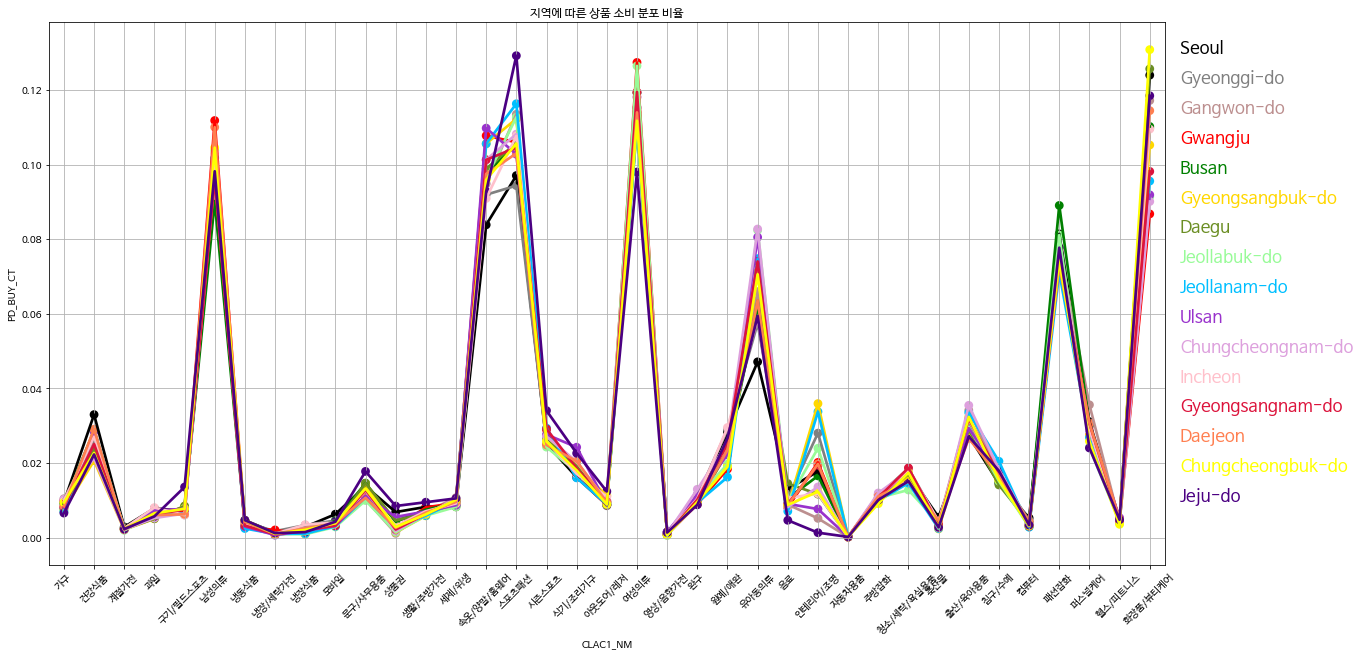

In [29]:
f,ax1 = plt.subplots(figsize =(20,10))
zone_list = prod_mas_sess['ZON_NM'].unique()
color_list = ['black','gray','rosybrown','red','green','gold','olivedrab','palegreen','deepskyblue',
              'darkorchid','plum','pink', 'crimson', 'coral', 'yellow', 'indigo', 'orchid', 'pink'][:len(zone_list)]

plt.title("지역에 따른 상품 소비 분포 비율",)
plt.xticks(rotation=45)
for i in range(len(zone_list)):
    data = prod_mas_sess[prod_mas_sess['ZON_NM'] == zone_list[i]][['CLAC1_NM', 'PD_BUY_CT']].groupby('CLAC1_NM',as_index=False).sum()
    data['PD_BUY_CT'] = data['PD_BUY_CT']/data['PD_BUY_CT'].sum()
    sns.pointplot(x='CLAC1_NM',y='PD_BUY_CT',data=data, color=color_list[i],alpha=0.8)
for i in range(len(zone_list)):
    plt.text(37, 0.13-0.008*i, zone_list[i],color=color_list[i],fontsize = 17,style = 'italic')
plt.grid()
plt.show()

제주도 고객들은 스포츠 패션에 대한 수요가 타 지역에 비해 상당히 높음을 알 수 있다. 한편 인테리어나 건강식품, 여성의류, 패션잡화 등에서는 낮은 수치를 보였다.

# 데스크탑 고객들의 페이지 조회수, 세션 시간값 분포 파악하기

C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


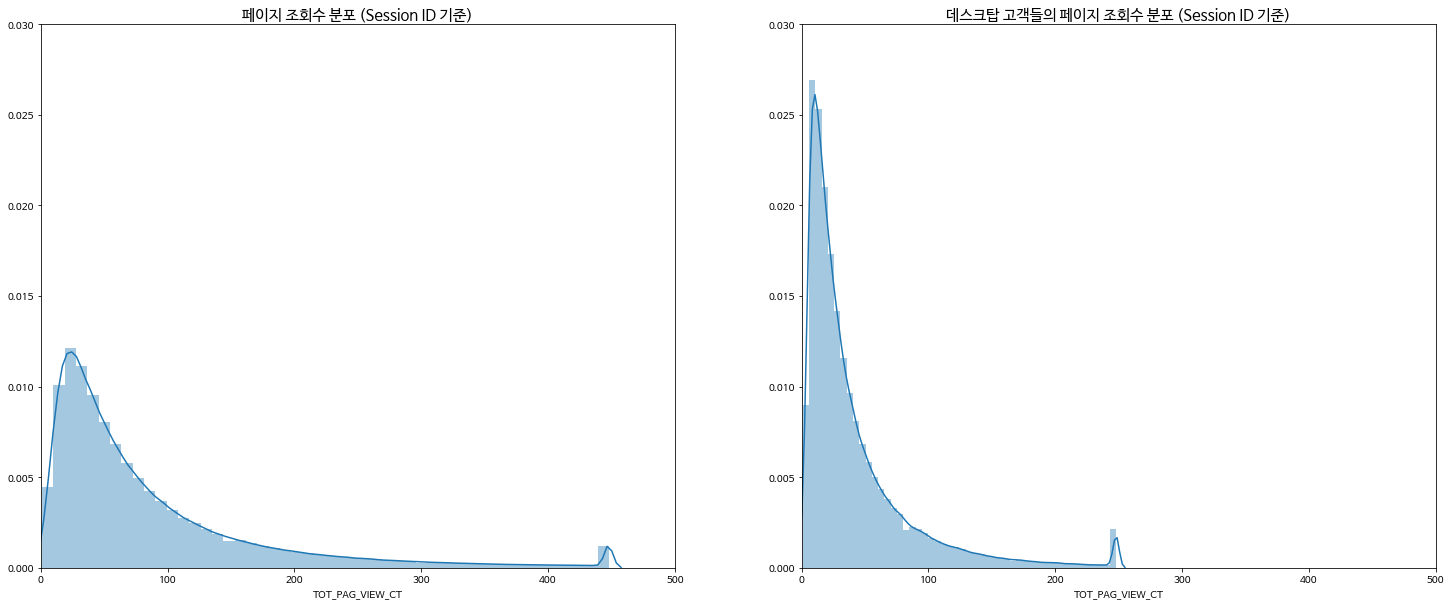

In [30]:
f,ax = plt.subplots(1,2, figsize = (25,10))

data = session['TOT_PAG_VIEW_CT'].dropna()
data[data>data.quantile(0.99)] = data.quantile(0.99)
ax[0].set_title("페이지 조회수 분포 (Session ID 기준)", fontsize=15)
ax[0].set_xlim(0,500)
ax[0].set_ylim(0,0.03)
sns.distplot(data, ax=ax[0])

data = session[session['DVC_CTG_NM']=='desktop']['TOT_PAG_VIEW_CT'].dropna()
data[data>data.quantile(0.99)] = data.quantile(0.99)
ax[1].set_title("데스크탑 고객들의 페이지 조회수 분포 (Session ID 기준)", fontsize=15)
ax[1].set_xlim(0,500)
ax[1].set_ylim(0,0.03)
sns.distplot(data, ax=ax[1])
plt.show()

C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


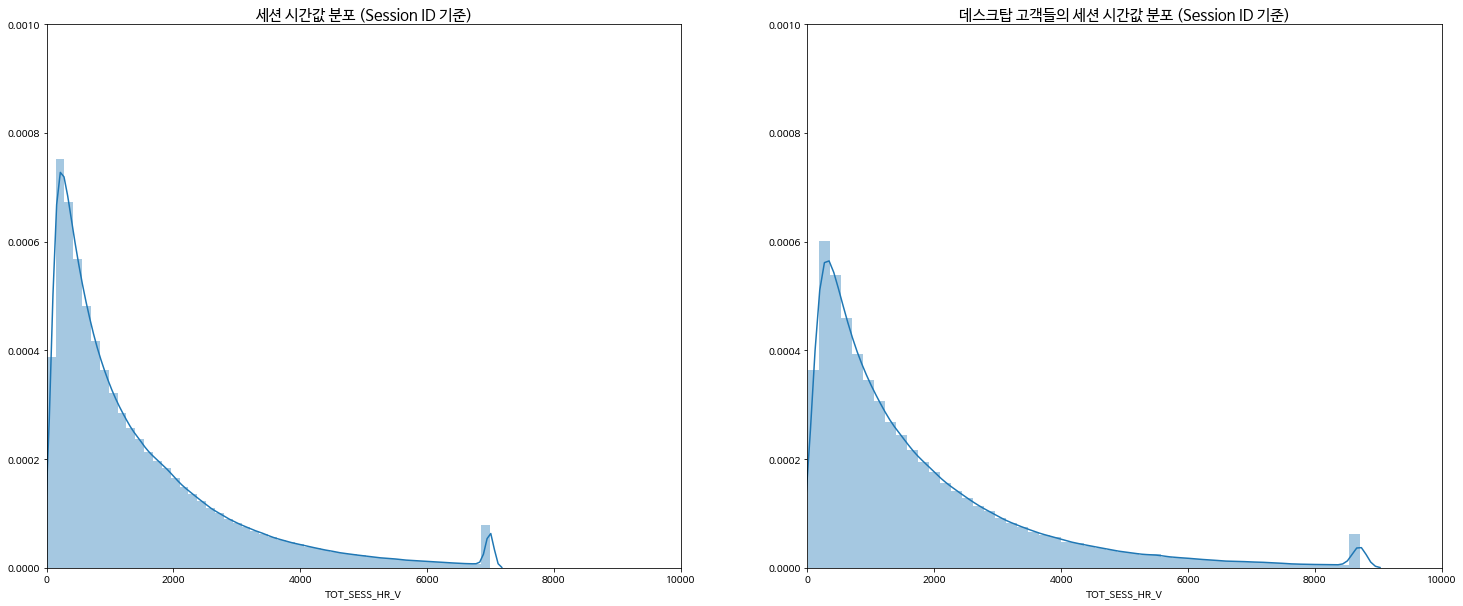

In [31]:
f,ax = plt.subplots(1,2, figsize = (25,10))

data = session['TOT_SESS_HR_V'].dropna().apply(lambda x:int(str(x).replace('.','').replace(',','')))
data[data>data.quantile(0.99)] = data.quantile(0.99)
ax[0].set_title("세션 시간값 분포 (Session ID 기준)", fontsize=15)
ax[0].set_xlim(0,10000)
ax[0].set_ylim(0,0.001)
sns.distplot(data, ax=ax[0])

data = session['TOT_SESS_HR_V'].dropna().apply(lambda x:int(str(x).replace('.','').replace(',','')))[session['DVC_CTG_NM']=='desktop']
data[data>data.quantile(0.99)] = data.quantile(0.99)
ax[1].set_title("데스크탑 고객들의 세션 시간값 분포 (Session ID 기준)", fontsize=15)
ax[1].set_xlim(0,10000)
ax[1].set_ylim(0,0.001)
sns.distplot(data, ax=ax[1])
plt.show()

데스크탑 고객들은 페이지 조회수가 적은 경향이 두드러지는 반면 세션 시간값은 조금더 많은 경향을 파악할 수 있다. 흥미롭게도 전체 분포와 차이가 상당히 크다. 데스크탑 고객들의 특성을 좀더 파악해보도록 하자 

# 데스크탑 고객들의 연령과 성별 분포

In [32]:
custom = pd.read_csv(data_dir + 'custom.csv')

In [33]:
cus_sess = session.merge(custom, on='CLNT_ID', how='left')

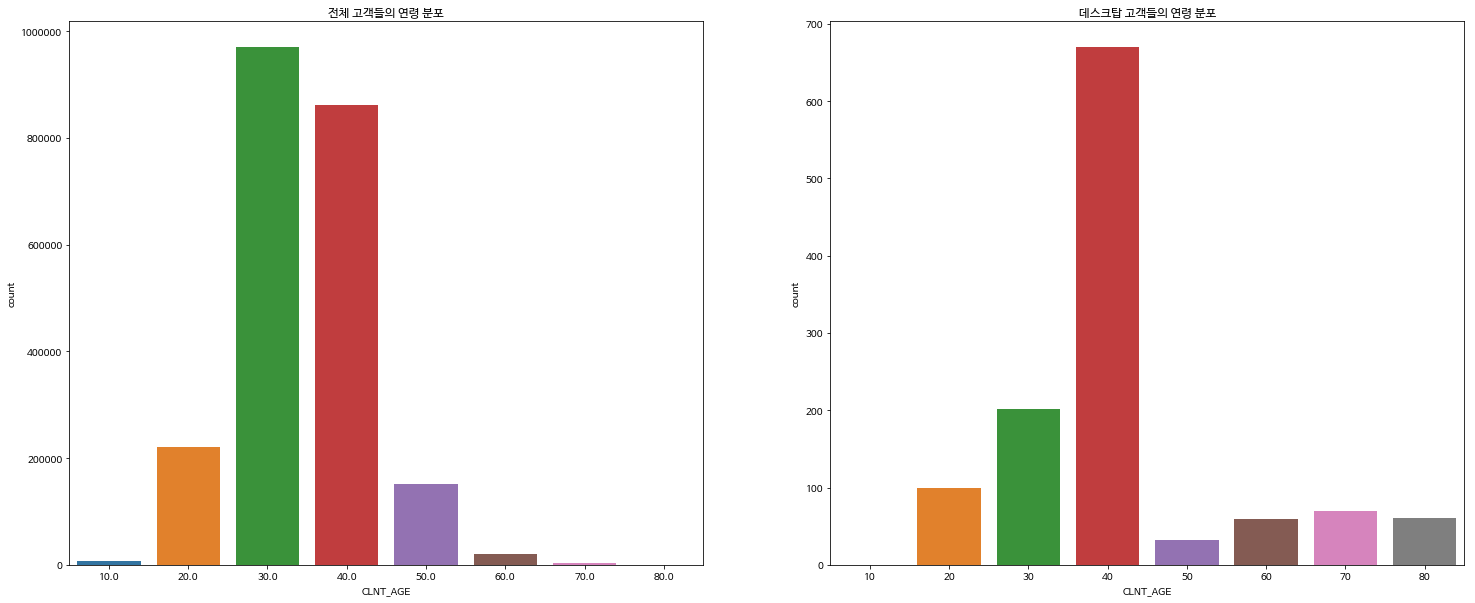

In [34]:
f, ax = plt.subplots(1,2, figsize=(25,10))
sns.countplot(cus_sess['CLNT_AGE'], ax=ax[0])
ax[0].set_title("전체 고객들의 연령 분포")

data = cus_sess[cus_sess['DVC_CTG_NM']=='desktop']
sns.countplot(data['CLNT_AGE'], ax=ax[1], order=[10,20,30,40,50,60,70,80])
ax[1].set_title("데스크탑 고객들의 연령 분포")
plt.show()

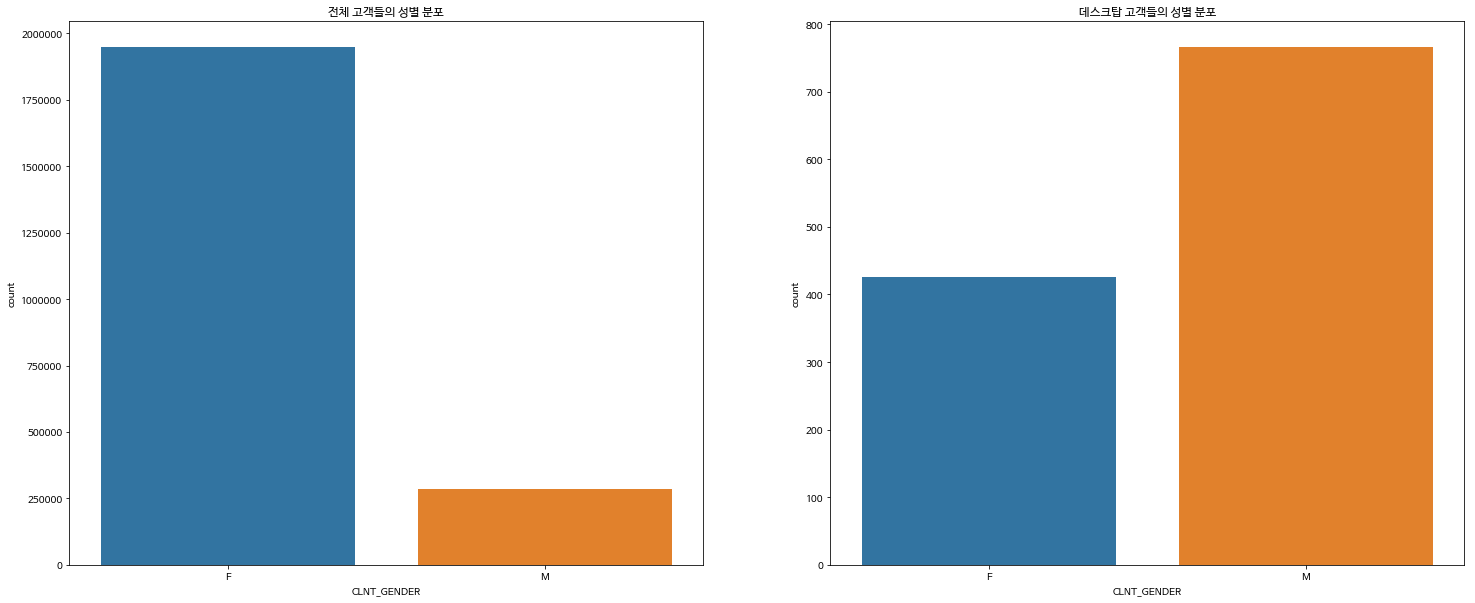

In [35]:
f, ax = plt.subplots(1,2, figsize=(25,10))
sns.countplot(cus_sess['CLNT_GENDER'], ax=ax[0])
ax[0].set_title("전체 고객들의 성별 분포")

data = cus_sess[cus_sess['DVC_CTG_NM']=='desktop']
sns.countplot(data['CLNT_GENDER'], ax=ax[1], order = ['F', 'M'])
ax[1].set_title("데스크탑 고객들의 성별 분포")
plt.show()

데스크탑 고객들의 연령, 성별 분포를 보면 40대 이상의 고객들의 비율과 남성 고객들의 비율이 확연히 높아짐을 볼 수 있다.

# 데스크탑 고객들의 검색량 분포 파악하기

In [36]:
search_1 = pd.read_csv(data_dir + 'Search1.csv')
search_1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2884943 entries, 0 to 2884942
Data columns (total 4 columns):
CLNT_ID       int64
SESS_ID       int64
KWD_NM        object
SEARCH_CNT    int64
dtypes: int64(3), object(1)
memory usage: 88.0+ MB


In [37]:
search_count_per_sess_id = search_1[['CLNT_ID', 'SESS_ID', 'SEARCH_CNT']].groupby(['CLNT_ID', 'SESS_ID'], as_index=False).sum()
sess_search1 = session.merge(search_count_per_sess_id, on=['CLNT_ID', 'SESS_ID'], how='left')

C:\Users\CSH\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


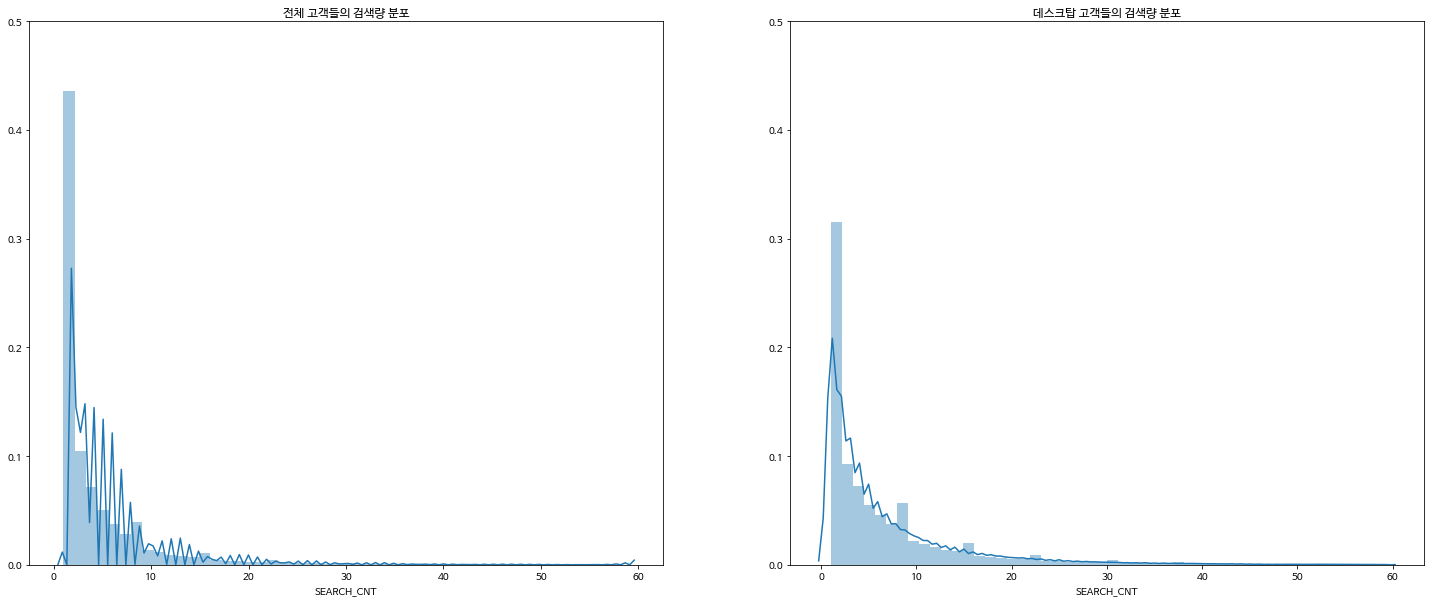

In [38]:
f, ax = plt.subplots(1,2, figsize=(25,10))
sns.distplot(search_count_per_sess_id['SEARCH_CNT'][search_count_per_sess_id['SEARCH_CNT']<60], ax=ax[0])
ax[0].set_title("전체 고객들의 검색량 분포")
ax[0].set_ylim(0,0.5)

data = sess_search1[sess_search1['DVC_CTG_NM']=='desktop'].dropna()
sns.distplot(data['SEARCH_CNT'][data['SEARCH_CNT']<60], ax=ax[1])
ax[1].set_title("데스크탑 고객들의 검색량 분포")
ax[1].set_ylim(0,0.5)
plt.show()

데스크탑 고객들은 전체 고객들에 비해 검색량이 많은 편임을 알 수 있다.

# 데스크탑 고객들의 검색단어 분포 파악하기

In [39]:
search1_sess = search_1.merge(session[['CLNT_ID', 'SESS_ID', 'DVC_CTG_NM']], how='left', on=['CLNT_ID', 'SESS_ID']).dropna()

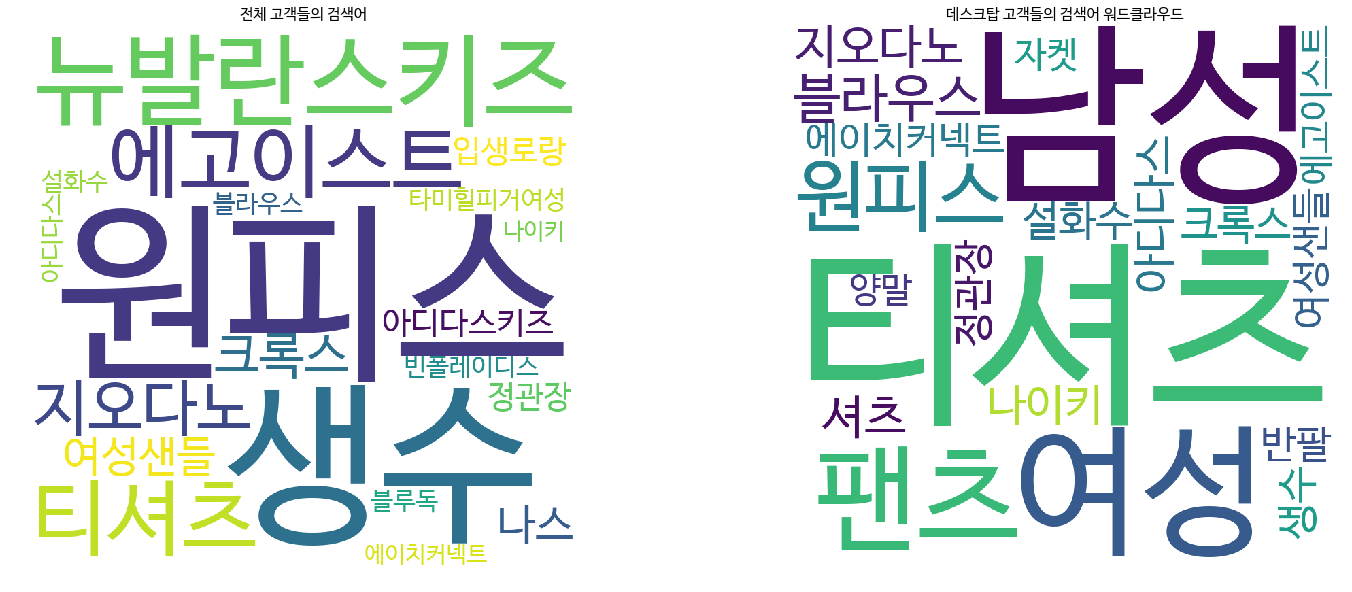

In [40]:
def getting_top_keywords(data, n):
    dic = dict(Counter(data))
    arr = np.array(list(dic.values()))
    top_idx = np.argsort(arr)[::-1][:n]
    return np.array(list(dic.keys()))[top_idx]

f, ax = plt.subplots(1, 2, figsize = (25,10))
n = 20

data = search1_sess
top_words = getting_top_keywords(data['KWD_NM'], n)
data = data['KWD_NM'][data['KWD_NM'].isin(top_words)]
wordcloud = WordCloud(font_path = 'c:\\windows\\fonts\\NanumBarunGothic.ttf' ,
                      width = 800, height = 800, max_words=100000,
                        background_color ='white',  collocations = False,
                        min_font_size = 10).generate(" ".join(data)) 
ax[0].imshow(wordcloud) 
ax[0].set_title("전체 고객들의 검색어", fontsize=15)
ax[0].axis('off')


data = search1_sess
data = data[data['DVC_CTG_NM'] == 'desktop']
top_words = getting_top_keywords(data['KWD_NM'], n)
data = data['KWD_NM'][data['KWD_NM'].isin(top_words)]
wordcloud = WordCloud(font_path = 'c:\\windows\\fonts\\NanumBarunGothic.ttf' ,
                      width = 800, height = 800, max_words=100000,
                        background_color ='white', collocations = False,
                        min_font_size = 10).generate(" ".join(data)) 
ax[1].imshow(wordcloud) 
ax[1].set_title("데스크탑 고객들의 검색어 워드클라우드", fontsize=15)
ax[1].axis('off')

plt.show()

데스크탑 고객들의 검색어는 주로 티셔츠, 남성, 팬츠, 셔츠, 여성, 원피스, 블라우스 등이 많은 것을 알 수 있다.

# 데스크탑 고객들의 상품 소비 분포 파악하기

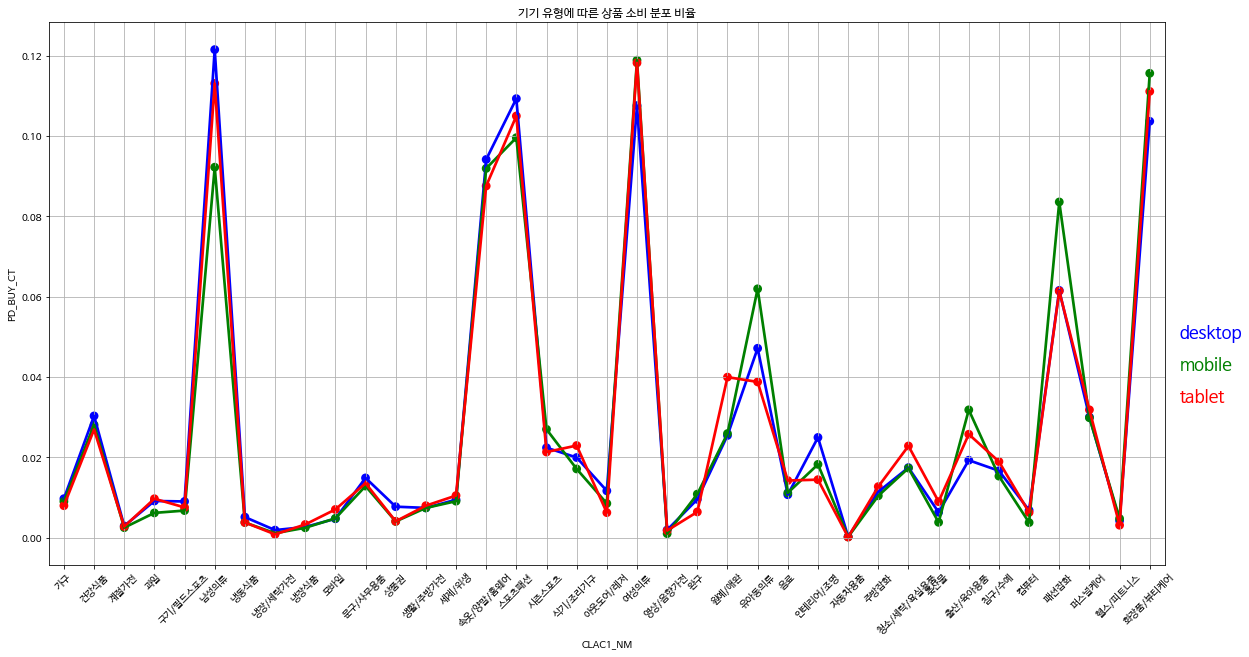

In [41]:
data = product[['CLNT_ID', 'SESS_ID', 'PD_C', 'PD_BUY_CT']].merge(master, on='PD_C', how='left')\
.merge(session[['CLNT_ID', 'SESS_ID','DVC_CTG_NM']], how='left', on=['CLNT_ID','SESS_ID'] )

plt.figure(figsize =(20,10))
device_list = data['DVC_CTG_NM'].unique()
color_list = ['blue','green','red']

plt.title("기기 유형에 따른 상품 소비 분포 비율")
plt.xticks(rotation=45)
for i in range(len(device_list)):
    data_mini = data[data['DVC_CTG_NM'] == device_list[i]][['CLAC1_NM', 'PD_BUY_CT']].groupby('CLAC1_NM',as_index=False).sum()
    data_mini['PD_BUY_CT'] = data_mini['PD_BUY_CT']/data_mini['PD_BUY_CT'].sum()
    sns.pointplot(x='CLAC1_NM',y='PD_BUY_CT',data=data_mini, color=color_list[i],alpha=0.8)
for i in range(len(device_list)):
    plt.text(37, 0.05-0.008*i, device_list[i],color=color_list[i],fontsize = 17,style = 'italic')
plt.grid()
plt.show()

데스크탑 고객들은 남성의류, 스포츠에 대한 구매가 매우 높은 반면에 유아동의류, 육아용품, 패션잡화 등에서는 매우 낮은 구매율을 보이고 있다.

### 정리
- 페이지 조회수와 세션 시간값은 모두 구매 건수와 반비례하는 경향이 있다. 다만 세션 시간값은 20,000초 이후로는 구매건수와 약하게 정비례한다.
- 데스크탑 고객, 제주도 고객은 구매 건수가 높은 경향이 있음
- 데스크탑 고객들은 페이지 조회건수는 낮은 반면 세션 시간값은 높은 경향이 뚜렷함
- 데스크탑 고객들은 주로 40대 이상의 고객들이 많고 남성이 많음
- 데스크탑 고객들의 검색량은 주로 많은 편임
- 데스크탑 고객들의 검색 단어는 주로 티셔츠, 남성, 팬츠, 셔츠, 여성, 원피스, 블라우스 등이 많음
- 데스크탑 고객들은 스포츠 패션, 남성 의류에 대해 비교적 높은 수요를 보임


# Still Proceeding ....